In [1]:
## information about how to use the script
from FiLMScope.recon_util import (add_sample_entry, get_all_sample_names,
                                  get_ss_volume_from_dataset)
from FiLMScope.util import play_video
from FiLMScope.calibration import CalibrationInfoManager
from FiLMScope.datasets import FSDataset
import os
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
from FiLMScope import path_to_data

import torch

In [2]:
# view already saved samples 
get_all_sample_names()

['skull_with_tool', 'finger']

In [3]:
# optional: select GPU to be used
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [4]:
# necessary information about the dataset 
sample_name = "knuckle_video"
# this is the data's location within "path_to_data"
folder = "/knuckle_video"
image_filename = folder + '/knuckle_video_4x4.nc'
calibration_filename = folder + '/calibration_information'
blank_filename = folder + "/blank_image.nc" # set to None if this was not acquired
bf = blank_filename 
if bf is not None:
    bf = path_to_data + '/' + bf

In [5]:
# some datasets were calibrated without saving the image shape used to calibrate
# this cell can be used to address that
manager = CalibrationInfoManager(path_to_data + calibration_filename)
if manager.image_shape is None:
    print("adding image shape")
    downsample = 4
    dataset = xr.open_dataset(path_to_data + image_filename)
    image_shape = (len(dataset.x) * downsample, len(dataset.y) * downsample)
    manager.image_shape = image_shape 
    manager.save_all_info()
    print(manager.image_shape)
    dataset = None

In [6]:
# set up a dataset with just the reference image 
ref_camera = CalibrationInfoManager(path_to_data + calibration_filename).reference_camera
downsample = 1
image_numbers = [ref_camera]
dataset = FSDataset(
    path_to_data + image_filename,
    path_to_data + calibration_filename,
    image_numbers,
    downsample,
    (0, 1, 0, 1),
    enforce_divisible=-1,
    frame_number=435, # set to -1 for single frame images
    blank_filename=bf
)

100%|██████████| 1/1 [00:00<00:00, 122.09it/s]
/home/clare/anaconda3/envs/filmscope2/lib/python3.8/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789115405/work/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


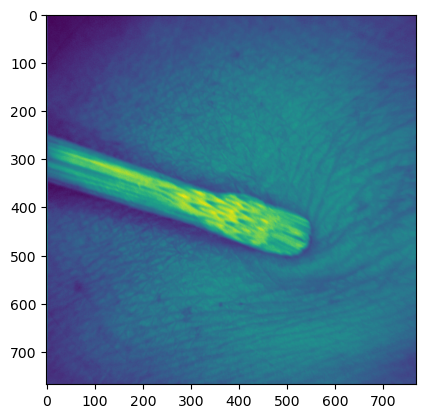

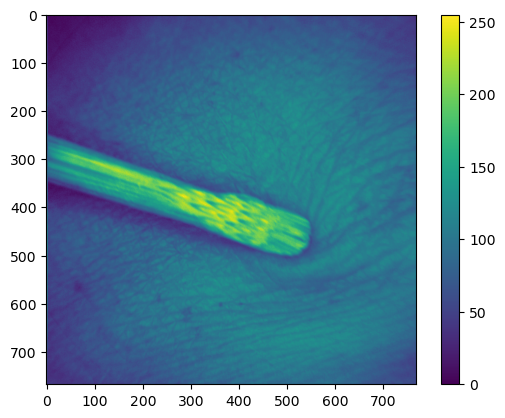

In [7]:
# pick a crop level that shows the desired FOV
crop = (0, 768, 0, 768) 
full_image = np.squeeze(dataset.reference_image)
crop_image = full_image[crop[0] : crop[1], crop[2] : crop[3]]

plt.imshow(crop_image)

plt.figure()
plt.imshow(full_image)
plt.colorbar()

In [8]:
# determine crop values
shape0 = dataset.images.shape[2]
shape1 = dataset.images.shape[3]

crop_values = (
    crop[0] / shape0,
    crop[1] / shape0,
    crop[2] / shape1,
    crop[3] / shape1,
)
print(crop_values)

(0.0, 1.0, 0.0, 1.0)


In [9]:
dataset = None

# new dataset with the crops
downsample = 1
image_numbers = manager.image_numbers
dataset = FSDataset(
    path_to_data + image_filename,
    path_to_data + calibration_filename,
    image_numbers,
    downsample,
    crop_values,
    enforce_divisible=-1,
    frame_number=430,
    blank_filename=bf
)

100%|██████████| 48/48 [00:00<00:00, 191.32it/s]


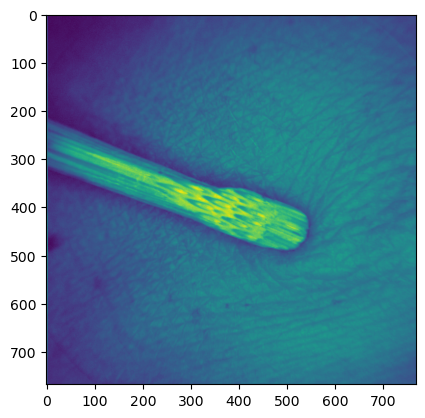

In [10]:
plt.imshow(dataset.images[40].squeeze())

In [12]:
# find depth extents
low_plane = -7
high_plane = 4

num = 30
depths = np.linspace(low_plane, high_plane, num, endpoint=True)
depth_values = torch.from_numpy(depths).to(torch.float32).cuda()

batch_size = 10
volume = get_ss_volume_from_dataset(dataset, batch_size, depth_values, get_squared=False)
volume = volume.squeeze().cpu().numpy()

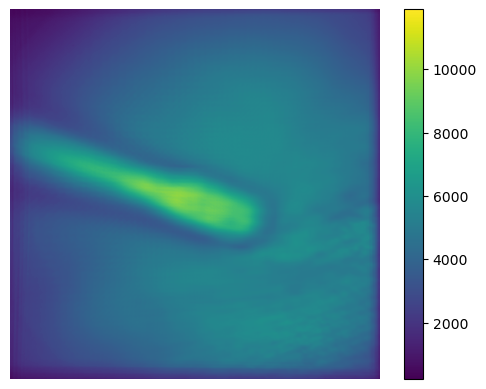

In [13]:
play_video(volume)

Text(0.5, 1.0, '-3.21 mm')

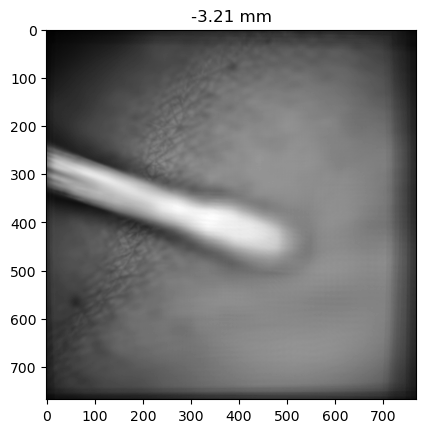

In [14]:
idx = 10
plt.imshow(volume[idx], cmap='gray')
plt.title("{:.2f} mm".format(depths[idx]))

In [15]:
# make the full sample entry
info = {
    "folder": folder,
    "sample_name": sample_name,
    "calibration_filename": calibration_filename,
    "image_filename": image_filename,
    "crop_values": crop_values,
    "depth_range": (low_plane, high_plane),
    "blank_filename": blank_filename,
}

In [17]:
# and save it!
add_sample_entry(sample_name, info, overwrite=False)

entry added, not overwriting


{'folder': '/knuckle_video',
 'sample_name': 'knuckle_video',
 'calibration_filename': '/knuckle_video/calibration_information',
 'image_filename': '/knuckle_video/knuckle_video_4x4.nc',
 'crop_values': [0.0, 1.0, 0.0, 1.0],
 'depth_range': [-7, 4],
 'blank_filename': '/knuckle_video/blank_image.nc'}